## CS 5630 Final Project   
Support Vector Machine Classifiers   
Dan Mrachko

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Load Metrics: I copied this from Aleksei because I like the way he did it.   

Small change: pos_label in specificity is 1 because of how I encoded the output (I want True violent crimes as positive label)   

In [2]:
def all_metrics(y_true, y_pred):
    print("accuracy:\t{:.3f}".format(metrics.accuracy_score(y_true, y_pred)))
    print("sensitivity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred)))
    print("specificity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred, pos_label=1)))
    print("kappa:    \t{:.3f}".format(metrics.cohen_kappa_score(y_true, y_pred)))

### Load the San Francisco data and prep for modeling

In [3]:
data = pd.read_csv('../data/cleaned_data/SanFrancisco.csv')
data.head(5)

# drop low/no correlation columns
data.drop(inplace=True, columns=['Unnamed: 0', 'Dates', 'Category', 'street1', 'street2', 'Address'])
# keeping str1 and str2 for now

data['violent'].value_counts()

# integer-encode 'violent' before splitting into testing and training data
encode_map = {"violent": {True:1, False:0}}
violent_map = ['False','True']
data = data.replace(encode_map)

data.head(5)

,DayOfWeek,PdDistrict,X,Y,year,month,day,hour,violent,str1,str2
0,2,NORTHERN,-122.425892,37.774599,2015,5,13,23,1,OAK ST,LAGUNA ST
1,2,NORTHERN,-122.425892,37.774599,2015,5,13,23,0,OAK ST,LAGUNA ST
2,2,NORTHERN,-122.424363,37.800414,2015,5,13,23,0,VANNESS AV,GREENWICH ST
3,2,NORTHERN,-122.426995,37.800873,2015,5,13,23,0,other,other
4,2,PARK,-122.438738,37.771541,2015,5,13,23,0,other,other


### Split into Training and Testing sets

In [4]:
y_data = data.loc[:,'violent']
x_data = data.loc[:,data.columns!='violent']

# convert all non-numeric columns in x to dummie values
x_data = pd.get_dummies(x_data)

#80-20 split
testing_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=testing_size, random_state = 12)

# verify
print(f'X training size: {x_train.shape}')
print(f'Y training size: {y_train.shape}')
print(f'X testing size: {x_test.shape}')
print(f'Y testing size {y_test.shape}')

x_data.head()

X training size: (702385, 419)
Y training size: (702385,)
X testing size: (175597, 419)
Y testing size (175597,)


,DayOfWeek,X,Y,year,month,day,hour,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,str2_VANNESS AV,str2_VERMONT ST,str2_VICENTE ST,str2_WALLER ST,str2_WASHINGTON ST,str2_WEBSTER ST,str2_WINSTON DR,str2_WISCONSIN ST,str2_YORK ST,str2_other
0,2,-122.425892,37.774599,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,-122.425892,37.774599,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-122.424363,37.800414,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,-122.426995,37.800873,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,-122.438738,37.771541,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Create an Initial Linear SVM Classification Model without tuning to see how long it takes to train

In [5]:
svc_init = svm.LinearSVC(dual=False, C=1, random_state=14)

svc_init.fit(x_train, y_train)

y_pred_train = svc_init.predict(x_train)
y_pred_test = svc_init.predict(x_test)

print('Training data metrics:')
all_metrics(y_train, y_pred_train)

print("\nTesting data metrics:")
all_metrics(y_test, y_pred_test)

Training data metrics:
accuracy:	0.594
sensitivity: 	0.676
specificity: 	0.676
kappa:    	0.187

Testing data metrics:
accuracy:	0.595
sensitivity: 	0.675
specificity: 	0.675
kappa:    	0.188


### Define a K-fold for cross-validation

In [5]:
kfold = KFold(n_splits=10, shuffle=True, random_state=13)

### Parameter Grid

In [6]:
svc_linear_params = {'C':[0.01, 0.1, 1, 10, 100],
                     'class_weight':[None, 'balanced']}

svc_linear = svm.LinearSVC(dual=False, random_state=15)

# grid for parameter optimization - optimize using F1 Score
svc_linear_grid = GridSearchCV(estimator=svc_linear, param_grid=svc_linear_params, scoring='f1', cv=kfold)

svc_linear_grid.fit(x_train, y_train)

KeyboardInterrupt: 

### Best Parameters from Tuning

In [34]:
print(f'Best Parameters: {svc_linear_grid.best_params_}')
print(f'With F1 Score: {svc_linear_grid.best_score_:.4f}')

Best Parameters: {'C': 0.1, 'class_weight': None}
With F1 Score: 0.6291


### Fit Linear SVC Model using best Parameters

In [7]:
#svc_linear = svm.LinearSVC(dual=False, random_state=16, 
#                           C=svc_linear_grid.best_params_['C'], 
#                           class_weight = svc_linear_grid.best_params_['class_weight'])

svc_linear = svm.LinearSVC(dual=False, random_state=16, 
                           C=0.1, 
                           class_weight = None)


svc_linear.fit(x_train, y_train)

LinearSVC(C=0.1, dual=False, random_state=16)

### Performance Metrics

accuracy:	0.595
sensitivity: 	0.680
specificity: 	0.680
kappa:    	0.188


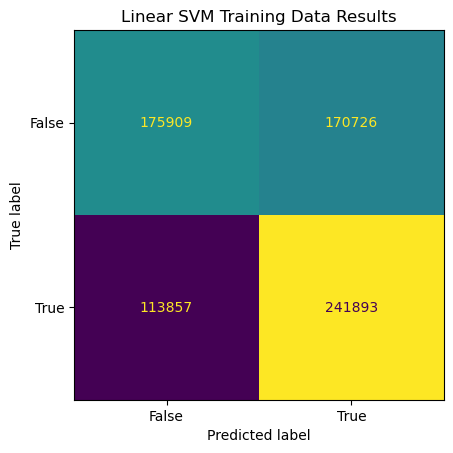

In [8]:
svc_linear_train_pred = svc_linear.predict(x_train)
cm_train = confusion_matrix([violent_map[val] for val in y_train], 
                            [violent_map[val] for val in svc_linear_train_pred])

ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels=violent_map).plot(colorbar=False)
plt.title('Linear SVM Training Data Results')

plt.savefig('linear_svm_conf_mat.png')

all_metrics(y_train, svc_linear_train_pred)

# results:
#accuracy:	0.595
#sensitivity: 	0.680
#specificity: 	0.680
#kappa:    	0.188

accuracy:	0.595
sensitivity: 	0.679
specificity: 	0.679
kappa:    	0.188


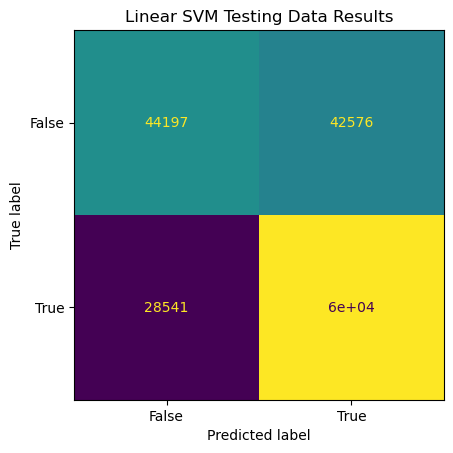

In [9]:
svc_linear_test_pred = svc_linear.predict(x_test)
cm_test = confusion_matrix([violent_map[val] for val in y_test],
                           [violent_map[val] for val in svc_linear_test_pred])

ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels=violent_map).plot(colorbar=False)
plt.title('Linear SVM Testing Data Results')

plt.savefig('linear_svm_conf_mat_testing.png')

all_metrics(y_test, svc_linear_test_pred)

## SVM With Radial Basis Function (RBF) Kernel

### Tune parameters

In [5]:
#svm_rbf_params = {'C':[0.01, 0.1, 1, 10, 100],
#                   'gamma': [0.001, 0.01, 0.1, 1, 10]}

# With the above grid, the code ran for over 7 hours. I'm convinced there was a bug
# or an infinite loop caused by failure to overcome the stopping criteria threshold,
# so I have removed the most extreme values from the tuning parameter list.

#svm_rbf_params = {'C':[0.1, 1, 10],
#                   'gamma': [0.01, 0.1, 1]}

#svm_rbf = svm.SVC(kernel='rbf')

#svm_rbf_grid = GridSearchCV(estimator=svm_rbf,
#                            param_grid=svm_rbf_params,
#                            scoring='f1',
#                            cv=kfold)

# train the grid
#svm_rbf_grid.fit(x_train, y_train)

### Best parameters after tuning

In [ ]:
#print(f'Best Parameters: {svm_rbf_grid.best_params_}')
#print(f'with F1 score: {svm_rbf_grid.best_score_:.4f}')

### Fit RBF SVM with best parameters

In [ ]:
#svm_rbf = svm.SVC(kernel='rbf', C=svm_rbf_grid.best_params_['C'],
#                  gamma=svm_rbf_grid.best_params_['gamma'])

#svm_rbf.fit(x_train, y_train)

## The above Tuning for RBF ran for 707 minutes without completion. This should not be the case, so I am going to manually tune.

In [6]:
#svm_rbf_1 = svm.SVC(kernel='rbf', C=0.1, gamma=0.1)

### From reading more about SVMs, I think I discovered the issue.   

It seems they create an NxN (N is number of samples) matrix to store the computed distances between the training points (the kernel function output).   

So using 80% of over 900k samples requires too much memory to store (more than 200 GB), so instead these distances were being computing every single time. That is billions of repeated computation, no wonder it was taking forever.   

So I am going to resample the data, but this time, I am going to take only 1% for training validation. Then I will try to train the model with final parameters in the OSC.   

In [8]:
svm_train_x, svm_test_x, svm_train_y, svm_test_y = train_test_split(x_data, y_data, train_size=0.01, random_state = 12)

print('Shape of x_data:', x_data.shape)
print('Shape of x_training:', svm_train_x.shape)


Shape of x_data: (877982, 419)
Shape of x_training: (8779, 419)


In [9]:
# First test on a single model and see how long it takes
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(svm_train_x, svm_train_y)

SVC()

### Above required 30 seconds. Proceed with parameter tuning

In [12]:
svm_rbf_params = {'C':[0.1, 1, 10],
                   'gamma': [0.01, 0.1, 1]}

svm_rbf = svm.SVC(kernel='rbf')

svm_rbf_grid = GridSearchCV(estimator=svm_rbf,
                            param_grid=svm_rbf_params,
                            scoring='f1',
                            cv=kfold)

# train the grid
svm_rbf_grid.fit(svm_train_x, svm_train_y)

print(f'Best Parameters: {svm_rbf_grid.best_params_}')
print(f'with F1 score: {svm_rbf_grid.best_score_:.4f}')

Best Parameters: {'C': 0.1, 'gamma': 1}
with F1 score: 0.6770


In [13]:
svm_rbf_params = {'C':[0.1],
                   'gamma': [10]}

svm_rbf = svm.SVC(kernel='rbf')

svm_rbf_grid = GridSearchCV(estimator=svm_rbf,
                            param_grid=svm_rbf_params,
                            scoring='f1',
                            cv=kfold)

# train the grid
svm_rbf_grid.fit(svm_train_x, svm_train_y)

print(f'Best Parameters: {svm_rbf_grid.best_params_}')
print(f'with F1 score: {svm_rbf_grid.best_score_:.4f}')

Best Parameters: {'C': 0.1, 'gamma': 10}
with F1 score: 0.6770


In [14]:
svm_rbf_params = {'C':[0.01],
                   'gamma': [1]}

svm_rbf = svm.SVC(kernel='rbf')

svm_rbf_grid = GridSearchCV(estimator=svm_rbf,
                            param_grid=svm_rbf_params,
                            scoring='f1',
                            cv=kfold)

# train the grid
svm_rbf_grid.fit(svm_train_x, svm_train_y)

print(f'Best Parameters: {svm_rbf_grid.best_params_}')
print(f'with F1 score: {svm_rbf_grid.best_score_:.4f}')

Best Parameters: {'C': 0.01, 'gamma': 1}
with F1 score: 0.6770


## Ignore the below code. A separate script will be written to execute final model training on the OSC.

### Predict on training and testing sets

In [ ]:
rbf_train_pred = svm_rbf.predict(x_train)
cm_training = confusion_matrix([violent_map[val] for val in y_train], 
                               [violent_map[val] for val in rbf_train_pred])

ConfusionMatrixDisplay(confusion_matrix=cm_training).plot(colorbar=False)
plt.title('RBF SVM Training Data Results')
plt.savefig('svm_rbf_conf_mat_training.png')

all_metrics(y_train, rbf_train_pred)

In [ ]:
rbf_test_pred = svm_rbf.predict(x_test)
cm_test = confusion_matrix([violent_map[val] for val in y_test],
                           [violent_map[val] for val in rbf_test_pred])
                           
ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(colorbar=False)
plt.title('RBF SVM Testing Data Results')
plt.savefig('svm_rbf_conf_mat_testing.png')

all_metrics(y_test, rbf_test_pred)